$$
\newcommand{\boldr}{\boldsymbol{r}}
\newcommand{\boldx}{\boldsymbol{x}}
$$

In [1]:
import typing as T
import numpy.typing as npt
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline


# Setting global matplotlib parameters
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 10)
matplotlib.rcParams['grid.alpha'] = 0.5
matplotlib.rcParams['grid.linestyle'] = '--'
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 'medium'
matplotlib.rcParams['ytick.labelsize'] = 'medium'
matplotlib.rcParams['legend.fontsize'] = 16

<a name='_toc'></a>
# Содержание
* [Фигуры Лиссажу](#lissajous_curve)
* [Создание искуственных данных](#artificial_data)
* [Задание](#task)
* [Калмановская фильтрация](#kalman_filtration)
    * [Калмановское состояние](#kalman_state)
    * [Transit & process](#kalman_transit_and_process)
    * [Запуск фильтрации](#kalman_filtration_running)
* [Визуализация результатов](#visualization)
* [MSE](#mse)

<a name='lissajous_curve'></a>
## Траектория Лиссажу<sup>[toc](#_toc)</sup>

\begin{align*}
x(t) = A_x cos(\omega_x t + \phi_x)\\
y(t) = A_y cos(\omega_y t + \phi_y)
\end{align*}

In [2]:
# Setting periods for X and Y axes
period_x = 30  # In [sec]onds
period_y = 45  # In [sec]onds
period = period_x * period_y / math.gcd(period_x, period_y) 

frequency_x = 1. / period_x  # In [Hz]
frequency_y = 1. / period_y  # In [Hz]

omega_x = 2 * np.pi * frequency_x
omega_y = 2 * np.pi * frequency_y

amplitude_x = 10.  # Amplitude along X axis
amplitude_y = 10.  # Amplitude along Y axis

phase_x = 0.
phase_y = np.pi / 4.

observation_period = 1. # Interval between system observation/trajectory sampling

In [3]:
min_time = 0.
max_time = period
times = np.arange(min_time, max_time, observation_period)

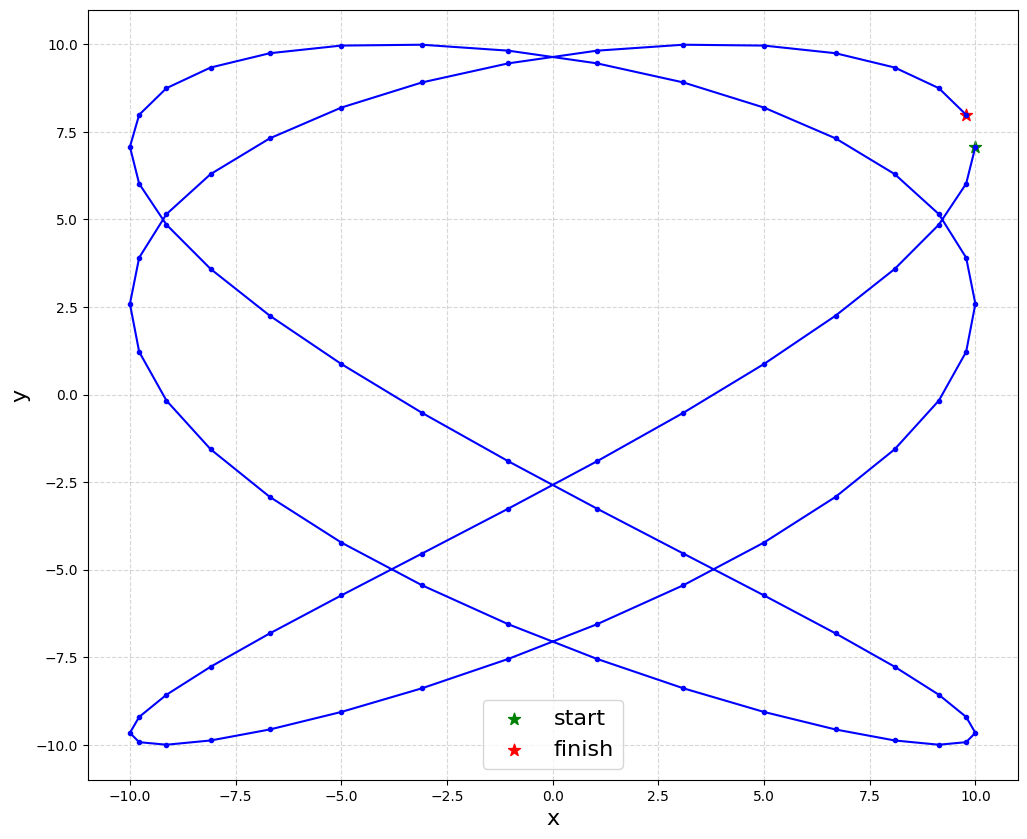

In [4]:
X = amplitude_x * np.cos(omega_x * times + phase_x)
Y = amplitude_y * np.cos(omega_y * times + phase_y)

plt.plot(X, Y, color='b', marker='o', ms=3)
plt.scatter(X[0], Y[0], marker='*', color='green', s=81, label='start')
plt.scatter(X[-1], Y[-1], marker='*', color='red', s=81, label='finish')
plt.grid(which='both')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

del X, Y

## Создание искуственных данных<sup>[toc](#_toc)</sup>

* Положение ($x$, $y$)
* Скорость $\upsilon$
* Угловая скорость $\omega$

#### Положение в момент времени $t$
Тут все просто, так как уравнение кривой $\boldr(t) = (x(t), y(t))^T$ нам задано явно:
\begin{align*}
x(t) = A_x \cos(\omega_x t + \phi_x)\\
y(t) = A_y \cos(\omega_y t + \phi_y)
\end{align*}

#### Скорость в момент времени $t$
Линейная скорость $\upsilon(t)$ опредляется на основе заданного уравнения кривой $\boldr(t)$ следующим образом:
$$
\upsilon(t)^2 = v_x(t)^2 + v_y(t)^2 = \left(\frac{dx(t)}{dt}\right)^2 + \left(\frac{dy(t)}{dt}\right)^2 = A_x^2 \omega_x \sin(\omega_x t + \phi_x) + A_y^2 \omega_y \sin(\omega_y t + \phi_y)
$$


#### Угловая скорость в момент времени $t$

$$
\gamma(t) = \arctan \frac{\upsilon_y(t)}{\upsilon_x(t)}
$$

$$
\omega(t) = \frac{d\gamma(t)}{dt} = \frac{d}{dt} \left( \arctan \frac{\upsilon_y(t)}{\upsilon_x(t)}\right) = \frac{1}{1 + (\upsilon_x(t)/\upsilon_y(t))^2} \frac{\frac{d\upsilon_x(t)}{dt} \upsilon_y(t) - \upsilon_x(t) \frac{d\upsilon_y(t)}{dt}}{\upsilon_y(t)^2} = \frac{1}{\upsilon_x(t)^2 + \upsilon_y(t)^2} \left( \frac{d\upsilon_x(t)}{dt} \upsilon_y(t) - \upsilon_x(t) \frac{d\upsilon_y(t)}{dt}\right) =
\frac{\dot{\upsilon_x}(t)\upsilon_y(t) - \upsilon_x(t) \dot{\upsilon}_y(t)}{\upsilon(t)^2}
$$

Заметим, что в рассматриваемом случае
$$
\dot{\upsilon_x}(t) = - \omega_x^2 x(t), \quad \dot{\upsilon_y}(t) = - \omega_y^2 y(t)
$$

Окончательно для угловой скорости получаем
$$
\omega(t) = \frac{-\omega_x^2 x(t) \upsilon_y(t) + \omega_y^2 y(t) \upsilon_x(t)}{\upsilon(t)^2}
$$

Можно проверить, что если точка движется по окружности, т.е. уравнение движения выглядит как то так: $x(t) = r\cos(\omega t)$, $y(t) = r\sin(\omega t)$, то подстановка в выражение выше дает $\omega(t) = \omega$.

### Создание gt-данных<sup>[toc](#_toc)</sup>

__Примечание__: gt &mdash; это сокращение от ground truth


In [5]:
gt_X = amplitude_x * np.cos(omega_x * times + phase_x)
gt_Y = amplitude_y * np.cos(omega_y * times + phase_y)
gt_VX = -omega_x * amplitude_x * np.sin(omega_x * times + phase_x)
gt_VY = -omega_y * amplitude_y * np.sin(omega_y * times + phase_y)
gt_V = np.sqrt(gt_VX**2 + gt_VY**2)
gt_Omega = (-omega_x**2 * gt_X * gt_VY + omega_y**2 * gt_Y * gt_VX) / gt_V

#### Посмотрим на то, как выглядят gt-данные<sup>[toc](#_toc)</sup>

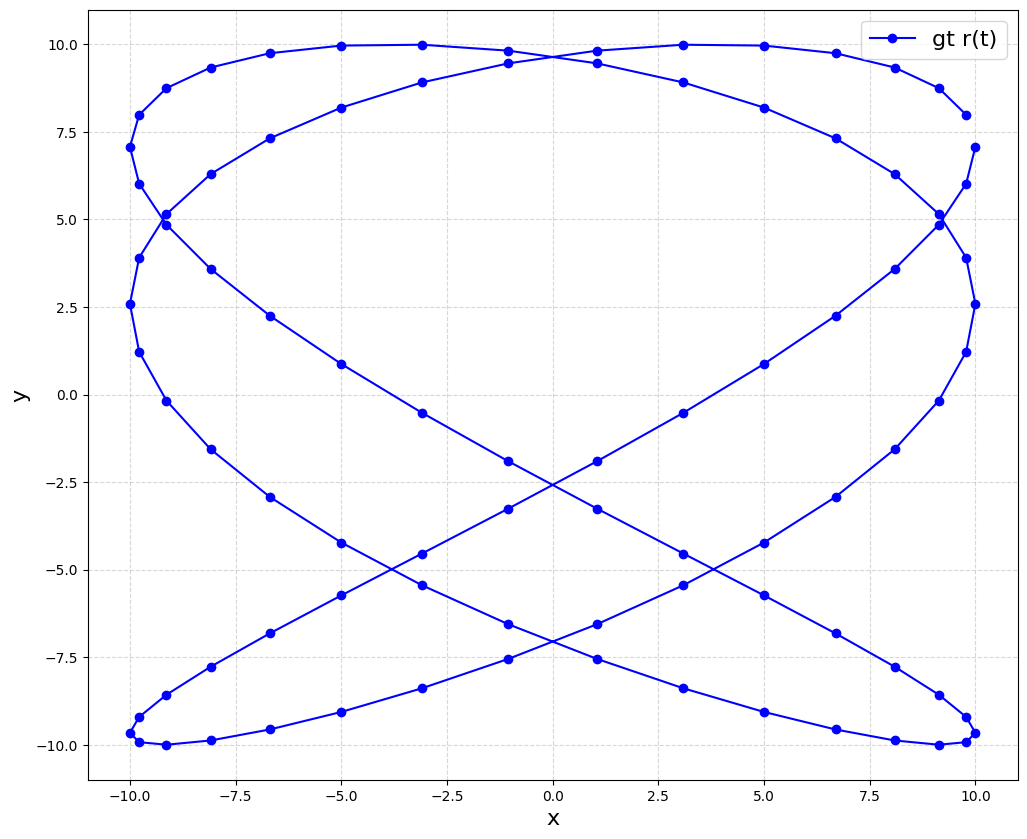

In [6]:
plt.plot(gt_X, gt_Y, label='gt r(t)', marker='o', color='b')
plt.grid(which='both')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

In [ ]:
plt.plot(times, gt_V, label='gt v(t)', marker='o', color='b')
plt.grid(which='both')
plt.xlabel('t')
plt.ylabel('v')
plt.legend();

In [ ]:
plt.plot(times, gt_Omega, label='gt omega(t)', marker='o', color='b')
plt.grid(which='both')
plt.xlabel('t')
plt.ylabel('omega')
plt.legend()

### Создание зашумленных данных<sup>[toc](#_toc)</sup>

В реальном мире данные, которые мы наблюдаем, зашумлены, поэтому промоделируем наблюадемые данные, добавив к gt-данным шумы. Можно считать, что мы наблюадем показания с трех сенсоров:
* GPS &mdash; дает наблюдения $\hat{x}$ и $\hat{y}$ положения точки в пространстве
* CAN &mdash; дает наблюдения линейной скорости $\hat{\upsilon}$
* IMU &mdash; дает наблюдения угловой скорости $\hat{\omega}$

In [7]:
gt_xy_noise_std = 1.  # GPS noise
gt_v_noise_std = 0.2  # CAN noise
gt_omega_noise_std = 0.2  # IMU noise

random_seed = 637577

In [8]:
random_state = np.random.RandomState(random_seed)
obs_X = gt_X + random_state.normal(loc=0., scale=gt_xy_noise_std, size=gt_X.shape)
obs_Y = gt_Y + random_state.normal(loc=0., scale=gt_xy_noise_std, size=gt_Y.shape)
obs_V = gt_V + random_state.normal(loc=0., scale=gt_v_noise_std, size=gt_V.shape)
obs_Omega = gt_Omega + random_state.normal(loc=0., scale=gt_omega_noise_std, size=gt_Omega.shape)

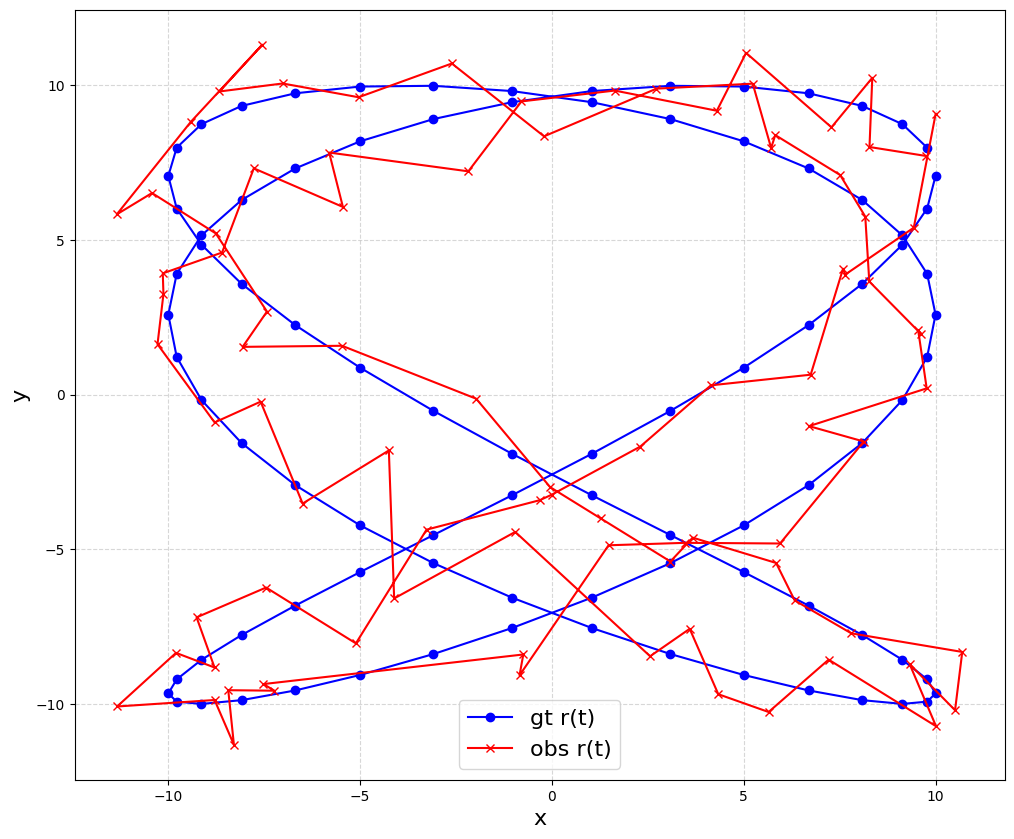

In [9]:
plt.plot(gt_X, gt_Y, label='gt r(t)', marker='o', color='b')
plt.plot(obs_X, obs_Y, label='obs r(t)', marker='x', color='r')
plt.grid(which='both')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

In [ ]:
plt.plot(times, gt_V, label='gt v(t)', marker='o', color='b')
plt.plot(times, obs_V, label='obs v(t)', marker='x', color='r')
plt.grid(which='both')
plt.xlabel('t')
plt.ylabel('v')
plt.legend();

In [ ]:
plt.plot(times, gt_Omega, label='gt omega(t)', marker='o', color='b')
plt.plot(times, obs_Omega, label='obs omega(t)', marker='x', color='r')
plt.grid(which='both')
plt.xlabel('t')
plt.ylabel('omega')
plt.legend()

<a name='task'></a>
## Задание<sup>[toc](#_toc)</sup>

Задача состоит в том, чтобы по зашумленным данным восстановить исходную **траекторию процесса**. 

> <span style='color:red'>Внимание.</span> Тут стоит подчеркнуть различие между понятиями &laquo;**траектории точки**&raquo; и &laquo;**траектории процесса**&raquo;. **Траектория точки** &mdash; это зависимость её координат от времени, т.е. в $\boldr(t)$. В то же время **траектория процесса** &mdash; это более широкое понятие, которое может включать в себя различные зависимости свойств системы от времени, т.е. наряду с $\boldr(t)$ траектория процесса вполне может включать в себя также зависимости $\upsilon(t)$, $\gamma(t)$ и т.п. Тут всё определяется конкретной постановкой задачи &mdash; по сути в траекторию процесса входят все те параметры, которые мы, как пользователи, хотим восстановить.

Для решения данной задачи предлагается использовать фильтра Калмана. При этом можно поэкспериментировать, последовательно добавляя данные в процесс восстановления, т.е. сначала восстановить траекторию только с исопльзованием наблюаемых показаний координат $\hat{x}$, $\hat{y}$. Затем добавить к процессу восстановления наблюдаемые скорости $\hat{\upsilon}$. Ну и в завершение добавить использование наблюдений угловых скоростей $\hat{\omega}$. В общем, если интересно, то можно посмотреть на то, как меняется качество восстановленной траектории с добавлением новых данных.

<a name='kalman_filtration'></a>
# Калмановская фильтрация<sup>[toc](#_toc)</sup>

<a name='kalman_state'></a>
## Калмановское состояние системы<sup>[toc](#_toc)</sup>

Предлагается использовать следующее состояние системы:
$$
\boldx(t) = \begin{pmatrix}
x\\
y\\
\gamma\\
v\\
\omega\\
\end{pmatrix},
$$
где 
* $x$ &mdash; координата точки по оси $X$
* $y$ &mdash; координата точки по оси $Y$
* $\gamma$ &mdash; угол рыскания; далее просто yaw
* $\upsilon$ &mdash; линейнаяа скорость
* $\omega$ &mdash; угловая скорость материальной точки

В семинарском ноутбуке в [есть описание данной системы](./seminar1_localization.ipynb#2d_with_yaw_model) с моделью эволюции и моделью наблюдений.

> <span style='color:red'>Внимание.</span> Модель эволюции, т.е. переход от момента времени $t$ к моменту $t + dt$ ничего не должен знать об истинной траектории системы, т.е. прогноз на состояние $\boldx(t + dt)$ делается только на основе знания состояния $\boldx(t)$ (точнее его распределения) на момент времени $t$.

<a name='kalman_transit_and_process'></a>
## Transit & process<sup>[toc](#_toc)</sup>

Для восстановления траектории нужно выполнить следующую последовательность шагов:
1. Проинициализировать состояние системы в момент времени 0. Тут есть простор для экспериментов:
    * Можно проинициализировать истинными значениями, при этом задав диагнональную матрицу ковариаций с относительно малымми значениями дисперсии. В этом случае мы ожидаем, что восстановленная траектория с самого начала пойдет рядом с gt-траекторией.
    * Можно проинициализировать нулевыми значениями, пир этом задав диагональную матрицу ковариаций с большими значениями дисперсии. Так мы моделируем полное незнание нами начального состояния. В таком случае мы ожидаем, что восстановленная траектория некоторое время будет приблжиаться к gt-траектории, а затем она пойдет рядом с ней. 
2. Далее обрабатываем первую пачку наблюдений в момент времени 0, и делаем прогноз на момент времени 1, ну и так далее. Однако пару моментов стоит обсудить детальнее:
    * **Transit**. Период наблюдений у нас составляет 1 секунду, т.е. всякий раз, обработав наблюдения в некоторый момент времени $t$, нам нужно перейти в момент времени $t + 1$. Фактически переход &mdash; это интегрирование вида:
         $$
         \boldx(t + T) = \boldx(t) + \int\limits_{t}^{t + T} \dot{\boldx}(t) dt.
         $$
      Такое интегрироване мы осуществляем по сути численно, используя некоторый шаг $\Delta t$. Если $\Delta t = T$, то в первом приближении получаем нечто такое:
         $$
         \boldx(t + T) \approx \boldx(t) + \dot{\boldx}(t) T
         $$
      т.е. делаем обычной линейный переход вдоль производной состояния. Но в нашем случае это приводит к тому, что между отрезками $t$ и $t + T$ мы будто бы двигаемся прямолинейно, так как по формуле выше
         
         \begin{align}
         x(t + T) = x(t) + \upsilon(t) T\\
         y(t + T) = y(t) + \upsilon(t) T
         \end{align}
      А у нас, между прочим, есть ещё и угловая скорость $\omega(t)$, которая постоянно поворачивает вектор направления движения. В результате приходим к тому, что такое грубое приближение может быть чревато значительным понижением точности (если интересно, то после написания кода можете провести сравнительный эксперимент, просто поставив ниже параметр `dt = observation_period`).
      
      Самый простой способ тут состоит в том, что переходить от момента времени $t$ к моменту $t + T$ небольшими последовательными шагами `dt`. Ниже по умолчанию поставлено `dt = 0.01`, т.е. делаем 100 переходов от момента $t$ к моменту $t + 1$.
    * **Process**. Все наблюдения у нас приходят пачками в одни и те же моменты времени, при этом может возникнуть вопрос, а важен ли порядок обработки. Ответ таков, что если все написано правильно, то не важен, так как процесс обработки показаний &mdash; это рассчет условной вероятности, а она не зависит от того, в какой последовательности применяется условность. Более того, можно объединить показания в единый вектор наблюдения с единой матрицей наблюдения, и тогда в каждый момент времени мы будем обрабатывать одно композитное показание с тем же результатом на выходе. В реальных системах так тоже иногда делается, но задача там осложняется тем, что показания сенсоров не синхронизированы и прилетают с разными периодами и задержками.

### Основные функции EKF<sup>[toc](#_toc)</sup>

В фильтре Калмана два основных действия:
* `transit` &mdash; переход от одного момента времени к следующему
* `process` &mdash; обработка показания


Данные функции уже реализованы, поэтому просто импортируем их. Но если есть желание, то можете написать свои - тут как удобно.

In [10]:
from sdc.kalman_filter import (
    kalman_transit_covariance,
    kalman_process_observation,
)

help(kalman_transit_covariance)
help(kalman_process_observation)

Help on function kalman_transit_covariance in module sdc.kalman_filter:

kalman_transit_covariance(S: numpy.ndarray, A: numpy.ndarray, R: numpy.ndarray) -> numpy.ndarray
    :param S: Current covariance matrix
    :param A: Either transition matrix or jacobian matrix
    :param R: Current noise covariance matrix

    :returns: Returns covariance matrix after transition
    :rtype: np.ndarray

Help on function kalman_process_observation in module sdc.kalman_filter:

kalman_process_observation(mu, S, observation, C, Q) -> Tuple[numpy.ndarray, numpy.ndarray]
    Performs processing of an observation coming from the model: z = C * x + noise
    :param mu: Current mean
    :param S: Current covariance matrix
    :param observation: Vector z
    :param C: Observation matrix
    :param Q: Noise covariance matrix (with zero mean)

    :returns: (mean, cov)



<a name='kalman_filtration_running'></a>
## Запуск фильтрации<sup>[toc](#_toc)</sup>

### Параметры<sup>[toc](#_toc)</sup>

In [12]:
# TODO: Тут требуется поставить какие-нибудь значения шумов. После того, как будет проведен первый успешный
# запуск фильтрации, можно поэкспериментировать с высставлением значений, чтобы улучшить восстановленную траекторию
kalman_xy_real_noise_std = 2
kalman_v_real_noise_std = 0.5
kalman_omega_real_noise_std = 0.5

dt = 0.01  # Transition time step

### Начальное состояние системы<sup>[toc](#_toc)</sup>

In [17]:
# TODO: Инициализировать каким-нибудь образом начальное состояние системы
# gt_YAW = np.array([0.])
kalman_initial_state_mean = np.array([gt_X, gt_Y, gt_V, gt_Omega]) 
kalman_initial_state_cov = None

# Initial state
kalman_initial_state_mean = np.zeros((2, 1), dtype=np.float64)
kalman_initial_state_mean[0] = 2
kalman_initial_state_cov = 0.05 * np.eye(2, dtype=np.float64)


In [20]:
import time

observation = np.array([obs_X, obs_Y, obs_V, obs_Omega])

noise_variances = np.zeros(2, dtype=np.float64)

POS_X_INDEX = 0
POS_Y_INDEX = 1
# YAW_INDEX = 2
VEL_INDEX = 2
OMEGA_INDEX = 3

# Скорость нарастания дисперсии в секунду
noise_covariance_density = np.diag([
    2.,   # Дисперсия x
    2.,   # Дисперсия y
    2.,   # Дисперсия yaw
    2.,   # Дисперсия скорости
    2.,   # Дисперсия угловой скорости
])

covariance_matrix = kalman_initial_state_cov

observation_matrix = np.eye(2, 5)

def move():
    # assert isinstance(dt, Timestamp)
    # Делаем предсказание на момент времени t + dt
    new_mu = get_next_state(state)

    J = get_state_jacobian_matrix()
    R = get_noise_covariance()
    S = covariance_matrix
    new_S = kalman_transit_covariance(S, J, R)

    state = new_mu
    covariance_matrix = new_S

    return state

def get_next_state(state):
    """Возвращает состояние в следующий момент времени."""
    x = state[POS_X_INDEX]
    y = state[POS_Y_INDEX]
    # yaw = state[YAW_INDEX]
    vel = state[VEL_INDEX]
    omega = state[OMEGA_INDEX]
    
    new_state = np.zeros_like(state)
    new_state[POS_X_INDEX] = x + vel * dt # * np.cos(yaw)
    new_state[POS_Y_INDEX] = y + vel * dt # * np.sin(yaw)
    # new_state[YAW_INDEX] = yaw + omega * dt
    new_state[VEL_INDEX] = vel
    new_state[OMEGA_INDEX] = omega
    
    return new_state

def get_state_jacobian_matrix(state):
    dt_sec = dt
    vel = state[VEL_INDEX]
    yaw = state[YAW_INDEX]
    J = np.eye(np.size(state), dtype=np.float64)
    J[POS_X_INDEX, VEL_INDEX] = np.cos(yaw) * dt_sec
    J[POS_Y_INDEX, VEL_INDEX] = np.sin(yaw) * dt_sec
    J[POS_X_INDEX, YAW_INDEX] = -vel * np.sin(yaw) * dt_sec
    J[POS_Y_INDEX, YAW_INDEX] = vel * np.cos(yaw) * dt_sec
    J[YAW_INDEX, OMEGA_INDEX] = dt_sec
    return J

def get_noise_covariance():
    """Возвращает матрицу ковариации шума для текущего момента времени car.time"""
    return noise_covariance_density * float(dt)

###

def process_observation(state, observation):
    C = observation_matrix()
    Q = get_noise_covariance()
    mu = state
    S = covariance_matrix
    new_mu, new_S = kalman_process_observation(mu, S, observation, C, Q)
    state = new_mu
    covariance_matrix = new_S



while time.time() < max_time:
    # Делаем реальный переход к моменту времени t + dt
    state = move()
    # Теперь обработаем наблюдения в момент t + dt
    print(state)
    process_observation(state, observation)
    print(f'after obs: {state}')

### Фильтрация<sup>[toc](#_toc)</sup>

In [35]:
# Реализовать калмановскую фильтрацию. На выходе должен быть заполненный список kalman_states_history

# List of (mean, cov) tuples
kalman_states_history: T.List[T.Tuple[np.ndarray, np.ndarray]] = None
    
# TODO: Написать код по фильтрации

### Извлекаем восстановленые значения параметров<sup>[toc](#_toc)</sup>

In [36]:
# После восстановления нужно инициализировать массивы ниже из kalman_states_history
'''
kalman_X = obs_X
kalman_Y = obs_Y
kalman_V = obs_V
kalman_Omega = obs_Omega
'''
kalman_X, kalman_Y, kalman_V, kalman_Omega = [], [], [], []
kalman_X.append(kalman_states_history[:][0][0])
kalman_Y.append(kalman_states_history[:][0][1])
kalman_V.append(kalman_states_history[:][0][3])
kalman_Omega.append(kalman_states_history[:][0][4])

TypeError: 'NoneType' object is not subscriptable

<a name='visualization'></a>
# Визуализация результатов<sup>[toc](#_toc)</sup>

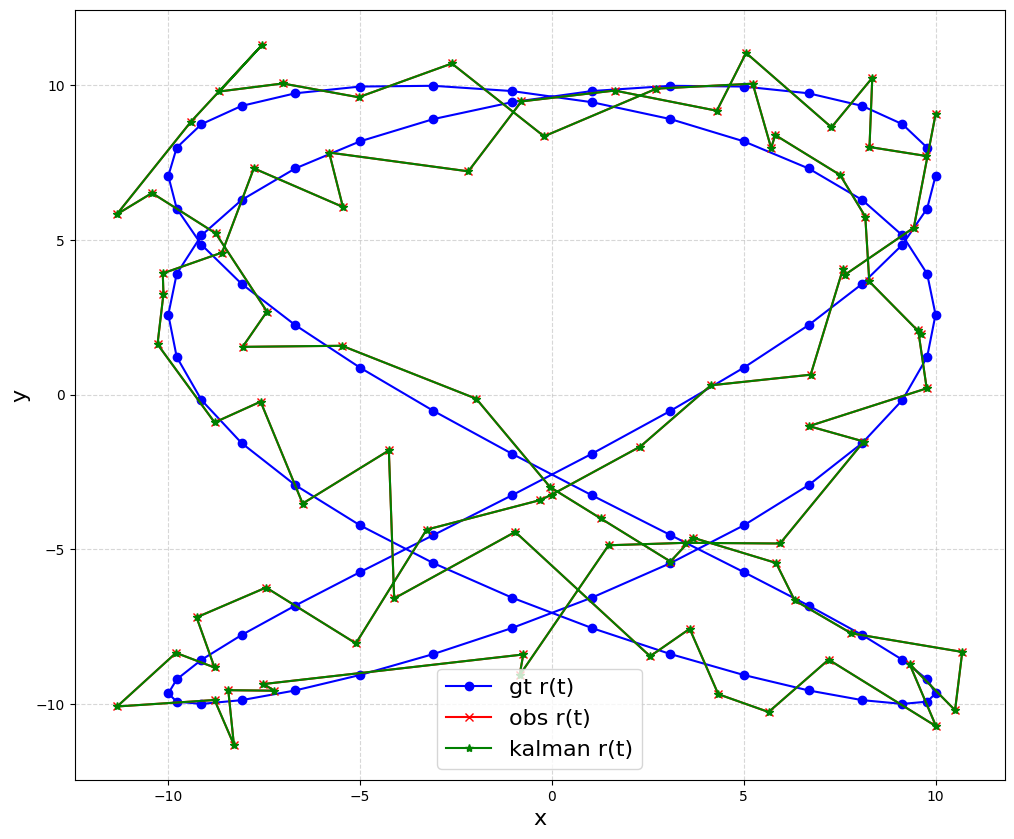

In [18]:
plt.plot(gt_X, gt_Y, label='gt r(t)', marker='o', color='b')
plt.plot(obs_X, obs_Y, label='obs r(t)', marker='x', color='r')
plt.plot(kalman_X, kalman_Y, label='kalman r(t)', marker='*', color='g')
plt.grid(which='both')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

In [ ]:
plt.plot(times, gt_V, label='gt v(t)', marker='o', color='b')
plt.plot(times, obs_V, label='obs v(t)', marker='x', color='r')
plt.plot(times, kalman_V, label='kalman v(t)', marker='*', color='g')
plt.grid(which='both')
plt.xlabel('t')
plt.ylabel('v')
plt.legend();

In [ ]:
plt.plot(times, gt_Omega, label='gt omega(t)', marker='o', color='b')
plt.plot(times, obs_Omega, label='obs omega(t)', marker='x', color='r')
plt.plot(times, kalman_Omega, label='kalman omega(t)', marker='x', color='g')
plt.grid(which='both')
plt.xlabel('t')
plt.ylabel('omega')
plt.legend()

<a name='mse'></a>
# MSE<sup>[toc](#_toc)<sup>
    
Тут требуется подсчитать MSE между gt-траекторией точки в пространстве, и восстановленной траекторией. Попробуйте подобрать такие параметры шума перехода и наблюдений, чтобы минимизировать MSE